### Setup

In [1]:
%%capture
!pip install tensorflow
!pip install tensorflow_datasets

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


### Load Data
We use the [GoEmotions dataset from TFDS](https://www.tensorflow.org/datasets/catalog/goemotions).

In [3]:
import tensorflow as tf
import tensorflow_datasets as tfds

import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
train_ds, test_ds, validation_ds = tfds.load('goemotions', split=['train', 'test', 'validation'], shuffle_files=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/goemotions/0.1.0.incompleteH09OQP/goemotions-train.tfrecord*...:   0%|    …

Generating validation examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/goemotions/0.1.0.incompleteH09OQP/goemotions-validation.tfrecord*...:   0%…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/goemotions/0.1.0.incompleteH09OQP/goemotions-test.tfrecord*...:   0%|     …

Dataset goemotions downloaded and prepared to /root/tensorflow_datasets/goemotions/0.1.0. Subsequent calls will reuse this data.


In [5]:
print(len(train_ds))
print(len(test_ds))
print(len(validation_ds))

43410
5427
5426


In [6]:
target_names = list()
for element in train_ds.take(1):
  for key in element.keys():
    if key != 'comment_text':
      target_names.append(key)

In [7]:
def parse_dataset_with_multiple_labels(ds, count=None):
  if count is None:
    count = len(ds)
  texts = list()
  labels = list()
  emotions = list()
  for element in ds.take(count):
    matched_labels = list()
    matched_emotions = ""
    idx = 0
    for key in element.keys():
      if key == 'comment_text':
        pass
      else:
        if element[key]:
          matched_labels.append(idx)
          matched_emotions += key + ","
        idx += 1
    matched_labels = matched_labels[:-1]
    matched_emotions = matched_emotions[:-1]
    
    texts.append(element['comment_text'].numpy().decode())
    labels.append(matched_labels)
    emotions.append(matched_emotions)
  return texts, labels

In [8]:
def parse_dataset_without_multiple_labels(ds, count=None):
  if count is None:
    count = len(ds)
  texts = list()
  labels = list()
  emotions = list()
  for element in ds.take(count):
    matched_labels = list()
    matched_emotions = ""
    idx = 0
    for key in element.keys():
      if key == 'comment_text':
        pass
      else:
        if element[key]:
          matched_labels.append(idx)
          matched_emotions += key + ","
        idx += 1
    matched_labels = matched_labels
    matched_emotions = matched_emotions[:-1]
    if len(matched_labels) == 1:
      texts.append(element['comment_text'].numpy().decode())
      labels.append(matched_labels[0])
      emotions.append(matched_emotions)
  return texts, tf.convert_to_tensor(labels), emotions

In [9]:
train_texts, train_labels, train_emotions = parse_dataset_without_multiple_labels(train_ds, 2)
print(train_texts)
print(train_labels)
print(train_emotions)

["It's just wholesome content, from questionable sources", 'This is actually awesome.']
tf.Tensor([20  0], shape=(2,), dtype=int32)
['neutral', 'admiration']


In [10]:
train_texts, train_labels, train_emotions = parse_dataset_without_multiple_labels(train_ds)
validation_texts, validation_labels, validation_emotions = parse_dataset_without_multiple_labels(validation_ds)
test_texts, test_labels, test_emotions = parse_dataset_without_multiple_labels(test_ds)

In [11]:
print(train_texts[:2])
print(train_labels[:2])
print(train_emotions[:2])

["It's just wholesome content, from questionable sources", 'This is actually awesome.']
tf.Tensor([20  0], shape=(2,), dtype=int32)
['neutral', 'admiration']


### Explore Data and Preprocess

In [ ]:
import pandas as pd
import seaborn as sns

In [ ]:
df_train = pd.DataFrame({'Text':train_texts, 'Label': train_labels, 'Emotion': train_emotions})
df_validation = pd.DataFrame({'Text':validation_texts, 'Label': validation_labels, 'Emotion': validation_emotions})

In [ ]:
df_train.head()

,Text,Label,Emotion
0,"It's just wholesome content, from questionable...",20,neutral
1,This is actually awesome.,0,admiration
2,I grew up on the other side of Ama but live in...,20,neutral
3,I second disagreeing that they are awesome.,10,disapproval
4,fucking fuck fuck,20,neutral


In [ ]:
df_train.shape

(36308, 3)

In [ ]:
df_train['Emotion'].value_counts()

neutral           12823
admiration         2710
approval           1873
gratitude          1857
amusement          1652
annoyance          1451
love               1427
disapproval        1402
curiosity          1389
anger              1025
optimism            861
confusion           858
joy                 853
sadness             817
surprise            720
disappointment      709
caring              649
realization         586
excitement          510
disgust             498
fear                430
desire              389
remorse             353
embarrassment       203
relief               88
nervousness          85
pride                51
grief                39
Name: Emotion, dtype: int64

In [ ]:
df_train['Emotion'].value_counts() / df_train.shape[0] * 100

neutral           35.317285
admiration         7.463920
approval           5.158643
gratitude          5.114575
amusement          4.549961
annoyance          3.996364
love               3.930263
disapproval        3.861408
curiosity          3.825603
anger              2.823069
optimism           2.371378
confusion          2.363116
joy                2.349344
sadness            2.250193
surprise           1.983034
disappointment     1.952738
caring             1.787485
realization        1.613969
excitement         1.404649
disgust            1.371599
fear               1.184312
desire             1.071389
remorse            0.972238
embarrassment      0.559105
relief             0.242371
nervousness        0.234108
pride              0.140465
grief              0.107414
Name: Emotion, dtype: float64

<Axes: xlabel='Emotion', ylabel='count'>

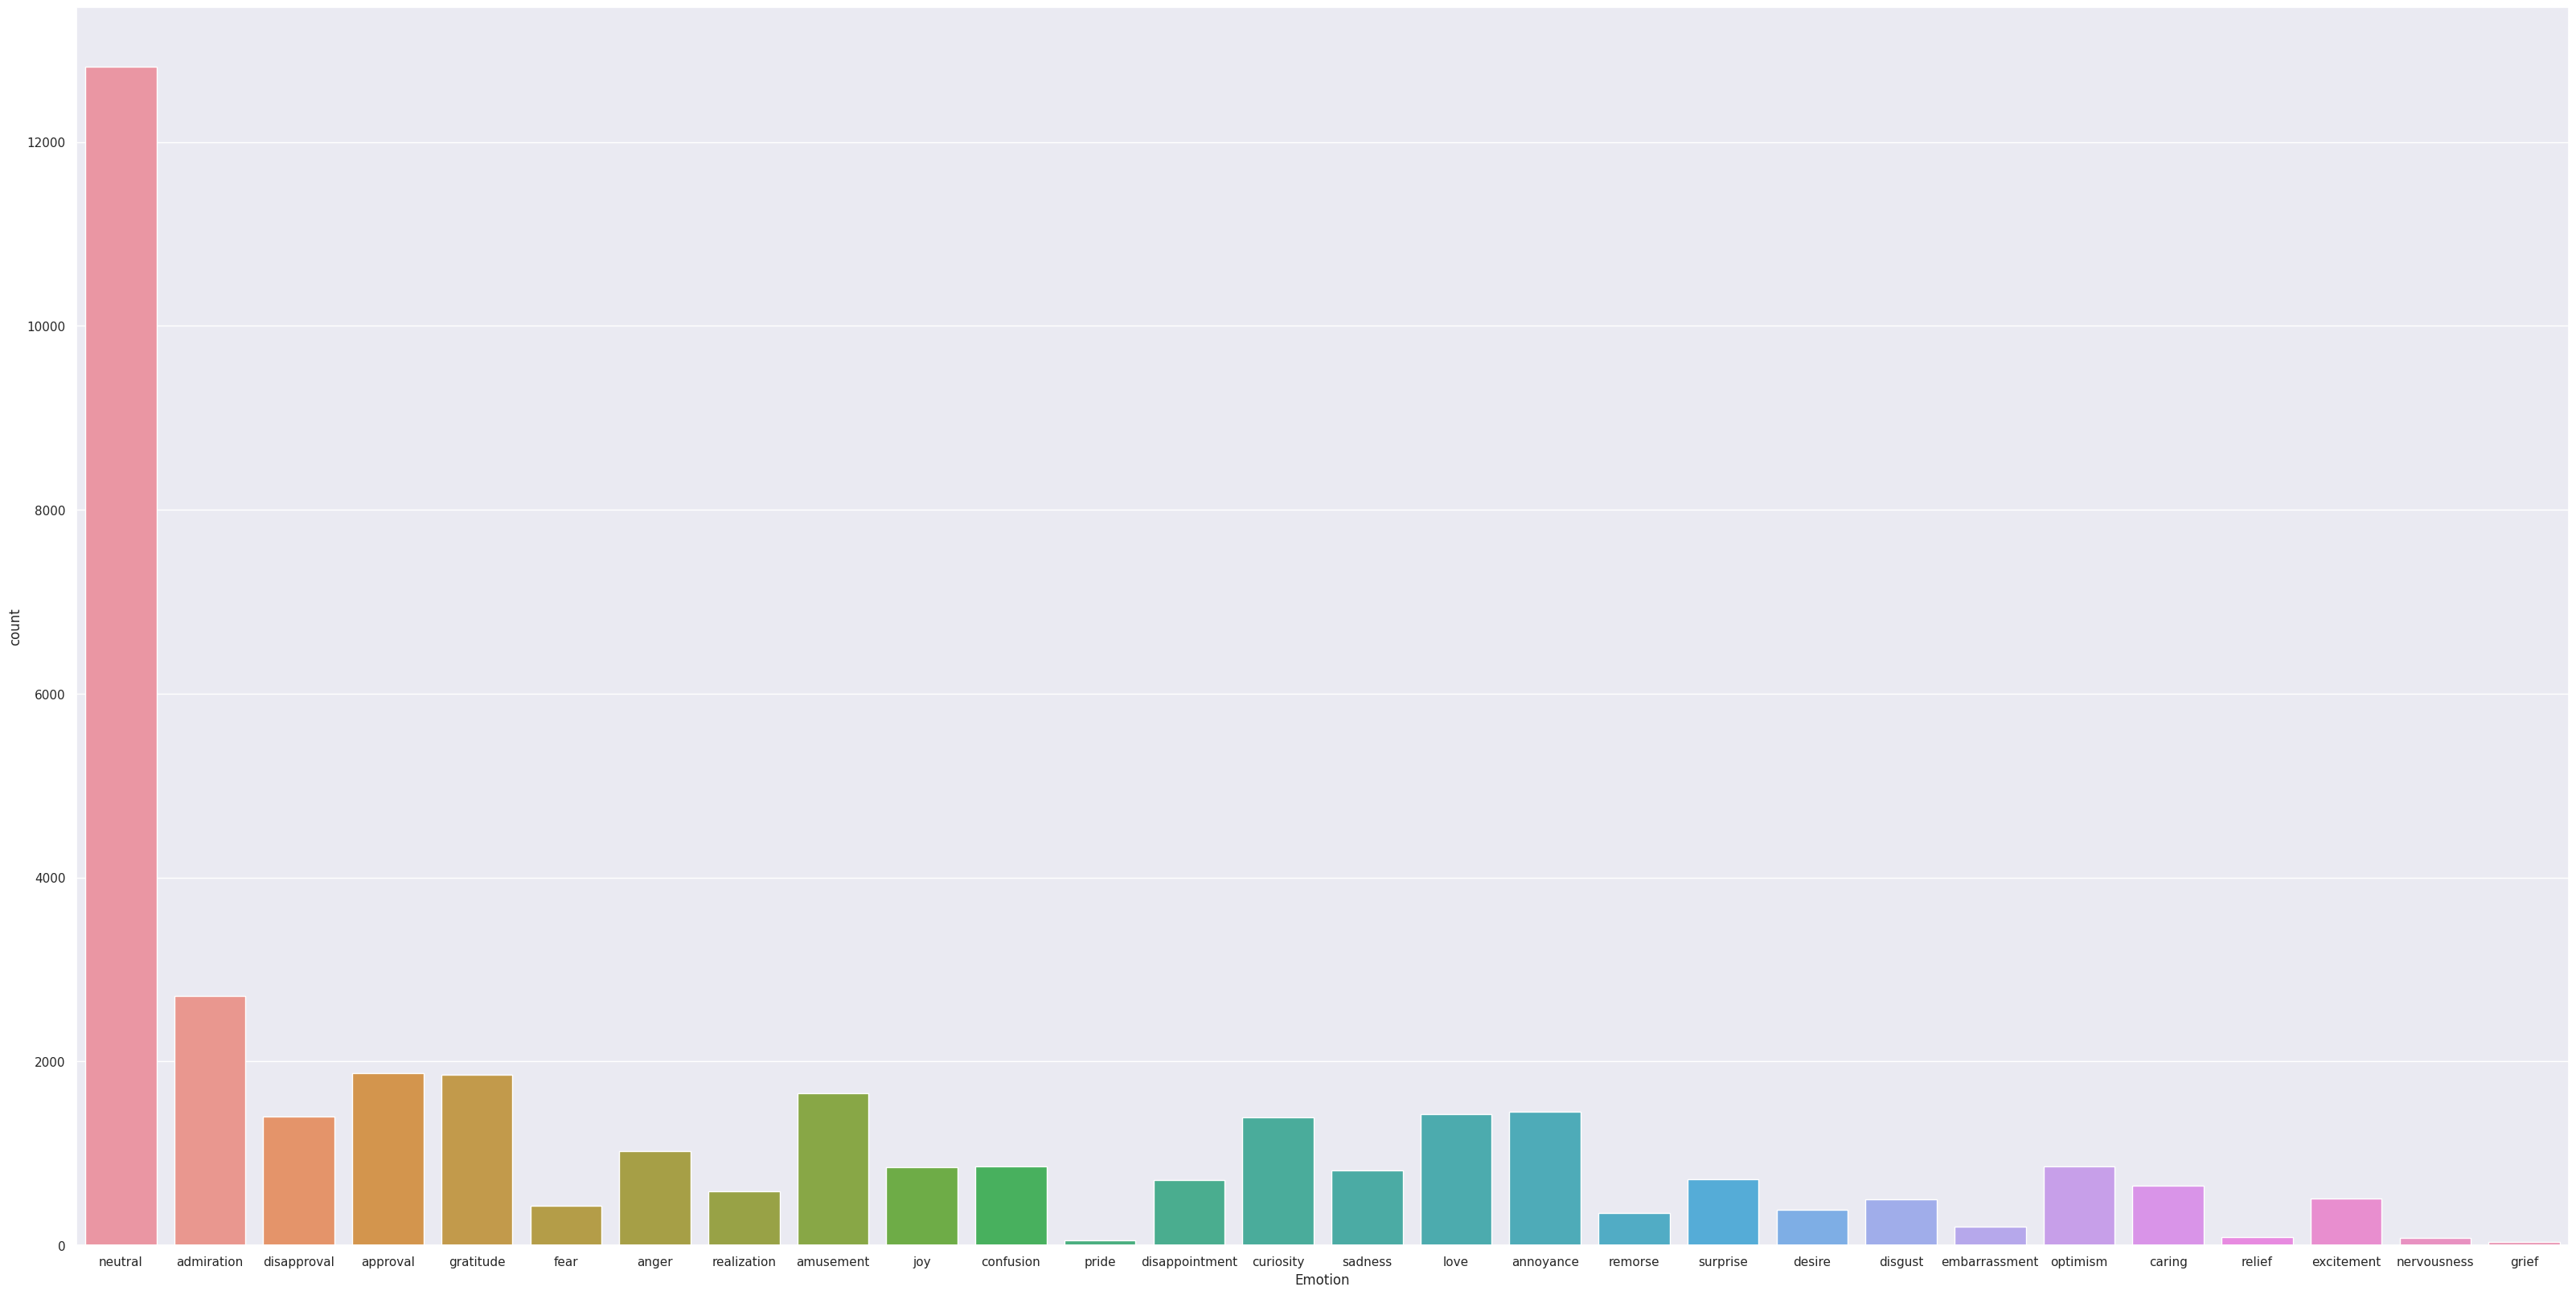

In [ ]:
sns.set(rc={'figure.figsize':(40,20)})
sns.countplot(x='Emotion', data=df_train)

In [ ]:
df_train.isnull().sum()

Text       0
Label      0
Emotion    0
dtype: int64

In [ ]:
def remove_duplications(df):
  # remove duplicated records
  df.duplicated().sum()
  index = df[df.duplicated() == True].index
  df.drop(index, axis = 0, inplace = True)
  df.reset_index(inplace=True, drop = True)
  df.duplicated().sum()

  # remove duplicated texts
  df[df['Text'].duplicated() == True]
  index = df[df['Text'].duplicated() == True].index
  df.drop(index, axis = 0, inplace = True)
  df.reset_index(inplace=True, drop = True)
  df[df['Text'].duplicated() == True]

In [ ]:
remove_duplications(df_train)
remove_duplications(df_validation)

In [ ]:
df_train['Emotion'].value_counts()

neutral           12789
admiration         2698
approval           1871
gratitude          1816
amusement          1650
annoyance          1448
love               1408
disapproval        1400
curiosity          1385
anger              1022
confusion           857
optimism            855
joy                 847
sadness             814
surprise            717
disappointment      708
caring              645
realization         585
excitement          506
disgust             495
fear                428
desire              389
remorse             353
embarrassment       202
relief               88
nervousness          85
pride                51
grief                39
Name: Emotion, dtype: int64

In [ ]:
df_validation['Emotion'].value_counts()

neutral           1592
admiration         325
gratitude          260
approval           258
disapproval        212
amusement          208
love               172
curiosity          164
annoyance          164
optimism           119
anger              109
joy                106
confusion          102
caring              96
surprise            95
disappointment      91
sadness             84
realization         74
disgust             61
fear                58
excitement          52
desire              52
remorse             40
embarrassment       20
pride                9
relief               8
nervousness          8
grief                6
Name: Emotion, dtype: int64

In [ ]:
max(df_train['Text'].apply(lambda text: len(text.split())))

32

In [ ]:
max(df_validation['Text'].apply(lambda text: len(text.split())))

30

In [ ]:
train_texts = df_train['Text']
train_labels = df_train['Label']

### Two-Stage Classification
Apply Clustering Model to GoEmotion Dataset
https://colab.research.google.com/drive/1nyoIpAwF16TjJtOIK-ZsB43HbxUhk1XW#scrollTo=IstLm_xJ_Rsj

In [21]:
%%capture
!pip install transformers

In [22]:
from transformers import BertTokenizer, TFBertModel
from tensorflow import keras

from transformers import logging as hf_logging
hf_logging.set_verbosity_error()

In [23]:
model_name = 'bert-base-cased'

In [24]:
bert_tokenizer = BertTokenizer.from_pretrained(model_name)
bert_model = TFBertModel.from_pretrained(model_name)

### Clustering Model, Define 1st and 2nd Stage Classification 

In [16]:
emotion_index_list = dict()
index_emotion_list = dict()

for idx, target_name in enumerate(target_names):
  index_emotion_list[idx] = target_name
  emotion_index_list[target_name] = idx

index_emotion_list

{0: 'admiration',
 1: 'amusement',
 2: 'anger',
 3: 'annoyance',
 4: 'approval',
 5: 'caring',
 6: 'confusion',
 7: 'curiosity',
 8: 'desire',
 9: 'disappointment',
 10: 'disapproval',
 11: 'disgust',
 12: 'embarrassment',
 13: 'excitement',
 14: 'fear',
 15: 'gratitude',
 16: 'grief',
 17: 'joy',
 18: 'love',
 19: 'nervousness',
 20: 'neutral',
 21: 'optimism',
 22: 'pride',
 23: 'realization',
 24: 'relief',
 25: 'remorse',
 26: 'sadness',
 27: 'surprise'}

In [29]:
emotion_index_list

{'admiration': 0,
 'amusement': 1,
 'anger': 2,
 'annoyance': 3,
 'approval': 4,
 'caring': 5,
 'confusion': 6,
 'curiosity': 7,
 'desire': 8,
 'disappointment': 9,
 'disapproval': 10,
 'disgust': 11,
 'embarrassment': 12,
 'excitement': 13,
 'fear': 14,
 'gratitude': 15,
 'grief': 16,
 'joy': 17,
 'love': 18,
 'nervousness': 19,
 'neutral': 20,
 'optimism': 21,
 'pride': 22,
 'realization': 23,
 'relief': 24,
 'remorse': 25,
 'sadness': 26,
 'surprise': 27}

In [30]:
clustering_mapping = {
    'aejl': ['amusement', 'excitement', 'joy', 'love'],
    'doc': ['desire', 'optimism', 'caring'],
    'pagr': ['pride', 'admiration', 'gratitude', 'relief'],
    'ar': ['approval', 'realization'],
    'daad': ['disapproval', 'annoyance', 'anger', 'disgust'],
    'gsder': ['grief', 'sadness', 'disappointment', 'embarrassment', 'remorse'],
    'nf': ['nervousness', 'fear'],
    'scc': ['surprise', 'curiosity', 'confusion'],
    'neutral': ['neutral']
}

In [31]:
# for 1st clustering model
reversed_clustering_mapping = dict()

for idx, key in enumerate(clustering_mapping):
  for idx2, emotion in enumerate(clustering_mapping[key]):
    reversed_clustering_mapping[emotion] = (idx, idx2, key)

reversed_clustering_mapping

{'amusement': (0, 0, 'aejl'),
 'excitement': (0, 1, 'aejl'),
 'joy': (0, 2, 'aejl'),
 'love': (0, 3, 'aejl'),
 'desire': (1, 0, 'doc'),
 'optimism': (1, 1, 'doc'),
 'caring': (1, 2, 'doc'),
 'pride': (2, 0, 'pagr'),
 'admiration': (2, 1, 'pagr'),
 'gratitude': (2, 2, 'pagr'),
 'relief': (2, 3, 'pagr'),
 'approval': (3, 0, 'ar'),
 'realization': (3, 1, 'ar'),
 'disapproval': (4, 0, 'daad'),
 'annoyance': (4, 1, 'daad'),
 'anger': (4, 2, 'daad'),
 'disgust': (4, 3, 'daad'),
 'grief': (5, 0, 'gsder'),
 'sadness': (5, 1, 'gsder'),
 'disappointment': (5, 2, 'gsder'),
 'embarrassment': (5, 3, 'gsder'),
 'remorse': (5, 4, 'gsder'),
 'nervousness': (6, 0, 'nf'),
 'fear': (6, 1, 'nf'),
 'surprise': (7, 0, 'scc'),
 'curiosity': (7, 1, 'scc'),
 'confusion': (7, 2, 'scc'),
 'neutral': (8, 0, 'neutral')}

### Prepare 1st Stage Data

In [17]:
MAX_SEQUENCE_LENGTH=256

In [18]:
train_encodings = bert_tokenizer(train_texts, truncation=True, padding='max_length', max_length=MAX_SEQUENCE_LENGTH, return_tensors='tf')
validation_encodings = bert_tokenizer(validation_texts, truncation=True, padding='max_length', max_length=MAX_SEQUENCE_LENGTH, return_tensors='tf')
test_encodings = bert_tokenizer(test_texts, truncation=True, padding='max_length', max_length=MAX_SEQUENCE_LENGTH, return_tensors='tf')

In [26]:
def map_to_clustering_1st_labels(labels):
  clustering_1st_labels = list()
  for label in labels:
    target_name = target_names[label]
    clustering_1st_labels.append(reversed_clustering_mapping[target_name][0])
  return tf.convert_to_tensor(clustering_1st_labels)

In [32]:
clustering_1st_train_labels = map_to_clustering_1st_labels(train_labels)
clustering_1st_validation_labels = map_to_clustering_1st_labels(validation_labels)
clustering_1st_test_labels = map_to_clustering_1st_labels(test_labels)

### Setup 1st Stage Clustering Model

In [33]:
NUM_CLASSES=len(clustering_mapping.keys())

In [34]:
BATCH_SIZE = 16
EPOCHS = 3

In [35]:
def create_1st_clustering_model(model_name=model_name,
                                max_length=MAX_SEQUENCE_LENGTH,
                                num_classes=NUM_CLASSES,
                                hidden_size=MAX_SEQUENCE_LENGTH+1, 
                                dropout=0.3,
                                learning_rate=0.00005):
  """
  Build a simple classification model with BERT. Use the Pooler Output for classification purposes.
  """
  bert_model = TFBertModel.from_pretrained(model_name)                                              

  ### YOUR CODE HERE
  bert_model.trainable = True

  input_ids = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int64, name='input_ids_layer')
  token_type_ids = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int64, name='token_type_ids_layer')
  attention_mask = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int64, name='attention_mask_layer')

  bert_inputs = {'input_ids': input_ids,
                 'token_type_ids': token_type_ids,
                 'attention_mask': attention_mask}  

  bert_out = bert_model(bert_inputs)
  pooler_token = bert_out[1]

  hidden = tf.keras.layers.Dense(hidden_size, activation='relu', name='hidden_layer')(pooler_token)
  hidden = tf.keras.layers.Dropout(dropout, name='dropout')(hidden)  
    
  classification = tf.keras.layers.Dense(num_classes, activation='softmax',name='classification_layer')(hidden)

  classification_model = tf.keras.Model(inputs=[input_ids, token_type_ids, attention_mask], outputs=[classification])
    
  classification_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                                 loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), 
                                 metrics='accuracy')

  ### END YOUR CODE
  return classification_model

In [36]:
the_1st_clustering_model = create_1st_clustering_model()

In [37]:
the_1st_clustering_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 attention_mask_layer (InputLay  [(None, 256)]       0           []                               
 er)                                                                                              
                                                                                                  
 input_ids_layer (InputLayer)   [(None, 256)]        0           []                               
                                                                                                  
 token_type_ids_layer (InputLay  [(None, 256)]       0           []                               
 er)                                                                                              
                                                                                              

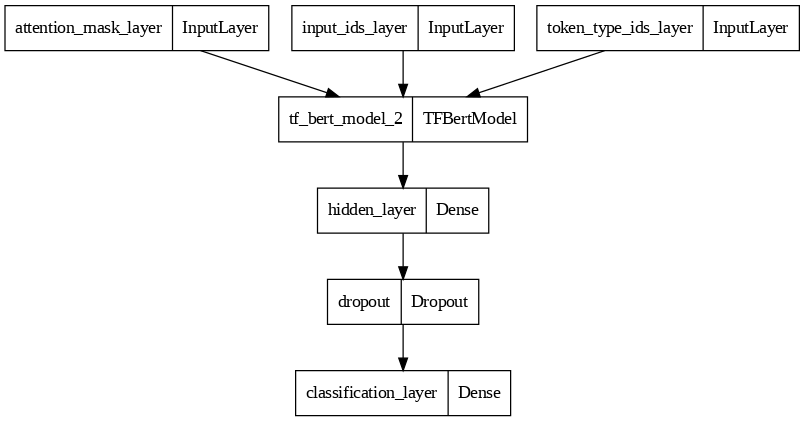

In [38]:
keras.utils.plot_model(the_1st_clustering_model, show_shapes=False, show_dtype=False, show_layer_names=True, dpi=90)

### Train 1st Stage Clustering Model

In [33]:
the_1st_clustering_model_history = the_1st_clustering_model.fit([train_encodings.input_ids, train_encodings.token_type_ids, train_encodings.attention_mask], 
                                                                clustering_1st_train_labels,   
                                                                validation_data=
                                                                ([validation_encodings.input_ids, validation_encodings.token_type_ids, validation_encodings.attention_mask], 
                                                                clustering_1st_validation_labels),    
                                                                batch_size=BATCH_SIZE, 
                                                                epochs=EPOCHS)  

Epoch 1/3
2270/2270 [==============================] - 1965s 846ms/step - loss: 1.1662 - accuracy: 0.6092 - val_loss: 0.9958 - val_accuracy: 0.6616
Epoch 2/3
2270/2270 [==============================] - 1917s 845ms/step - loss: 0.8922 - accuracy: 0.6908 - val_loss: 1.0001 - val_accuracy: 0.6609
Epoch 3/3
2270/2270 [==============================] - 1918s 845ms/step - loss: 0.7261 - accuracy: 0.7489 - val_loss: 1.1290 - val_accuracy: 0.6379


In [34]:
MODEL_PATH='/content/drive/MyDrive/UCB MIDS/W266/Final Project/Emotion Classification Model/'

the_1st_clustering_model.save(MODEL_PATH + '1st.clustering.model.h5')

### Save and Load 1st Stage Clustering Model

In [39]:
MODEL_PATH='/content/drive/MyDrive/UCB MIDS/W266/Final Project/Emotion Classification Model/'

custom_objects = {'TFBertModel': TFBertModel}

with tf.keras.utils.custom_object_scope(custom_objects):
  the_1st_clustering_model = keras.models.load_model(MODEL_PATH + '1st.clustering.model.h5')

In [40]:
the_1st_clustering_predictions = the_1st_clustering_model.predict([test_encodings.input_ids, test_encodings.token_type_ids, test_encodings.attention_mask])
the_1st_clustering_predictions = tf.argmax(the_1st_clustering_predictions, axis=-1)
the_1st_clustering_predictions


144/144 [==============================] - 81s 540ms/step


<tf.Tensor: shape=(4590,), dtype=int64, numpy=array([8, 8, 0, ..., 8, 0, 7])>

In [41]:
from sklearn.metrics import classification_report
print(classification_report(clustering_1st_test_labels, the_1st_clustering_predictions.numpy(), target_names=clustering_mapping.keys()))

              precision    recall  f1-score   support

        aejl       0.75      0.80      0.77       496
         doc       0.61      0.45      0.52       249
        pagr       0.80      0.78      0.79       622
          ar       0.37      0.36      0.37       325
        daad       0.51      0.64      0.56       596
       gsder       0.73      0.52      0.61       259
          nf       0.72      0.51      0.60        77
         scc       0.50      0.51      0.50       360
     neutral       0.66      0.66      0.66      1606

    accuracy                           0.63      4590
   macro avg       0.63      0.58      0.60      4590
weighted avg       0.64      0.63      0.63      4590



In [42]:
cm = tf.math.confusion_matrix(clustering_1st_test_labels, the_1st_clustering_predictions)
cm = cm/cm.numpy().sum(axis=1)[:, tf.newaxis]

Text(220.72222222222223, 0.5, 'True')

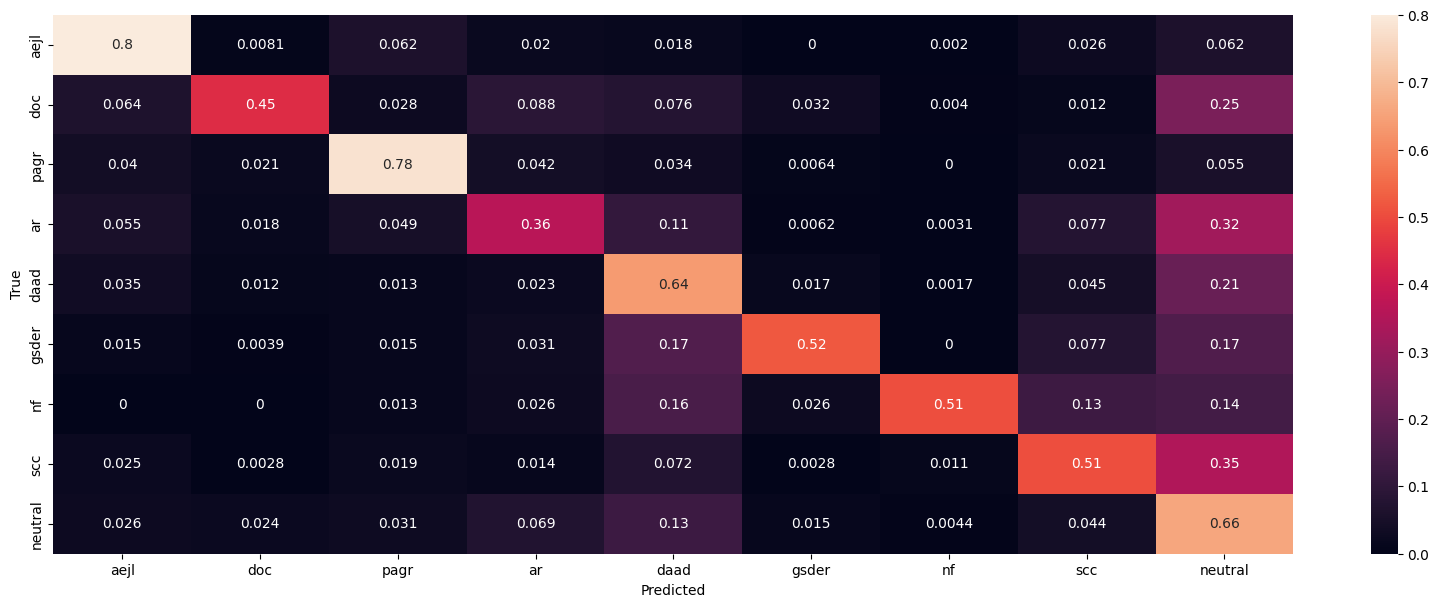

In [43]:
plt.figure(figsize=(20,7))
sns.heatmap(
    cm, annot=True,
    xticklabels=clustering_mapping.keys(),
    yticklabels=clustering_mapping.keys())
plt.xlabel("Predicted")
plt.ylabel("True")

### Setup 2nd Stage Clustering Model Data

In [44]:
def map_to_clustering_2nd_texts_and_labels(texts, labels, emotions):
  from collections import defaultdict
  the_2nd_clustering_texts = defaultdict(list)
  the_2nd_clustering_labels = defaultdict(list)
  the_2nd_clustering_emotions = defaultdict(list)

  for idx, emotion in enumerate(emotions):
    key = reversed_clustering_mapping[emotion][2]
    the_2nd_clustering_texts[key].append(texts[idx])
    the_2nd_clustering_labels[key].append(reversed_clustering_mapping[emotion][1])
    the_2nd_clustering_emotions[key].append(emotions[idx])
  
  for key in the_2nd_clustering_labels:
    the_2nd_clustering_labels[key] = tf.convert_to_tensor(the_2nd_clustering_labels[key])
  
  return the_2nd_clustering_texts, the_2nd_clustering_labels, the_2nd_clustering_emotions

In [45]:
the_2nd_clustering_train_texts, the_2nd_clustering_train_labels, the_2nd_clustering_train_emotions = map_to_clustering_2nd_texts_and_labels(train_texts, train_labels, train_emotions)
the_2nd_clustering_validation_texts, the_2nd_clustering_validation_labels, the_2nd_clustering_validation_emotions = map_to_clustering_2nd_texts_and_labels(validation_texts, validation_labels, validation_emotions)

### Setup 2nd Stage Clustering Model

In [50]:
BATCH_SIZE=8
EPOCHS=3

MAX_SEQUENCE_LENGTH=256

In [47]:
def create_2nd_clustering_model(
    num_classes,
    model_name=model_name,
    max_length=MAX_SEQUENCE_LENGTH,
    hidden_size=MAX_SEQUENCE_LENGTH + 1, 
    dropout=0.3,
    learning_rate=0.00005):
  """
  Build a simple classification model with BERT. Use the Pooler Output for classification purposes.
  """
  bert_model = TFBertModel.from_pretrained(model_name)                                              

  ### YOUR CODE HERE
  bert_model.trainable = True

  input_ids = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int64, name='input_ids_layer')
  token_type_ids = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int64, name='token_type_ids_layer')
  attention_mask = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int64, name='attention_mask_layer')

  bert_inputs = {'input_ids': input_ids,
                 'token_type_ids': token_type_ids,
                 'attention_mask': attention_mask}  

  bert_out = bert_model(bert_inputs)
  pooler_token = bert_out[1]

  hidden = tf.keras.layers.Dense(hidden_size, activation='relu', name='hidden_layer')(pooler_token)
  hidden = tf.keras.layers.Dropout(dropout, name='dropout')(hidden)  
    
  classification = tf.keras.layers.Dense(num_classes, activation='softmax',name='classification_layer')(hidden)

  classification_model = tf.keras.Model(inputs=[input_ids, token_type_ids, attention_mask], outputs=[classification])
    
  classification_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                                 loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), 
                                 metrics='accuracy')

  ### END YOUR CODE
  return classification_model

### Train and Save 2nd Stage Clustering Model

In [48]:
MODEL_PATH='/content/drive/MyDrive/UCB MIDS/W266/Final Project/Emotion Classification Model/'

In [51]:
the_2nd_clustering_model_history = dict()

for clustering in clustering_mapping:
  if clustering in ['aejl', 'doc', 'pagr', 'ar', 'daad']:
    continue
  if clustering != 'neutral':
    print("Training for the 2nd stage model of {}".format(clustering))

    # prepare data
    the_2nd_clustering_model = create_2nd_clustering_model(num_classes=len(clustering_mapping[clustering]))
    the_2nd_clustering_train_encodings = bert_tokenizer(the_2nd_clustering_train_texts[clustering], truncation=True, padding='max_length', max_length=MAX_SEQUENCE_LENGTH, return_tensors='tf')
    the_2nd_clustering_validation_encodings = bert_tokenizer(the_2nd_clustering_validation_texts[clustering], truncation=True, padding='max_length', max_length=MAX_SEQUENCE_LENGTH, return_tensors='tf')
    
    # train model
    the_2nd_clustering_model_history[clustering] = the_2nd_clustering_model.fit([the_2nd_clustering_train_encodings.input_ids, the_2nd_clustering_train_encodings.token_type_ids, the_2nd_clustering_train_encodings.attention_mask], 
                                                    the_2nd_clustering_train_labels[clustering],   
                                                    validation_data=
                                                    ([the_2nd_clustering_validation_encodings.input_ids, the_2nd_clustering_validation_encodings.token_type_ids, the_2nd_clustering_validation_encodings.attention_mask], 
                                                    the_2nd_clustering_validation_labels[clustering]),    
                                                    batch_size=BATCH_SIZE, 
                                                    epochs=EPOCHS)  
    # save model
    the_2nd_clustering_model.save(MODEL_PATH + '2nd.' + clustering + '.clustering.model.h5')
    del the_2nd_clustering_model

Training for the 2nd stage model of gsder
Epoch 1/3
266/266 [==============================] - 167s 457ms/step - loss: 1.1106 - accuracy: 0.5488 - val_loss: 0.6908 - val_accuracy: 0.7469
Epoch 2/3
266/266 [==============================] - 117s 441ms/step - loss: 0.7023 - accuracy: 0.7572 - val_loss: 0.7380 - val_accuracy: 0.7303
Epoch 3/3
266/266 [==============================] - 117s 441ms/step - loss: 0.4715 - accuracy: 0.8482 - val_loss: 0.7709 - val_accuracy: 0.7842
Training for the 2nd stage model of nf
Epoch 1/3
65/65 [==============================] - 74s 488ms/step - loss: 0.5108 - accuracy: 0.8078 - val_loss: 0.2965 - val_accuracy: 0.9091
Epoch 2/3
65/65 [==============================] - 29s 446ms/step - loss: 0.2828 - accuracy: 0.8874 - val_loss: 0.2503 - val_accuracy: 0.8636
Epoch 3/3
65/65 [==============================] - 29s 442ms/step - loss: 0.1026 - accuracy: 0.9612 - val_loss: 0.4880 - val_accuracy: 0.9242
Training for the 2nd stage model of scc
Epoch 1/3
371/371 

### Evaluate 2nd Clustering Model

In [ ]:
the_2nd_clustering_emotion_index_mapping = dict()

for emotion in reversed_clustering_mapping:
  key = str(reversed_clustering_mapping[emotion][0]) + '-' + str(reversed_clustering_mapping[emotion][1])
  value = emotion_index_list[emotion]
  the_2nd_clustering_emotion_index_mapping[key] = value

the_2nd_clustering_emotion_index_mapping

{'0-0': 20,
 '1-0': 23,
 '1-1': 6,
 '1-2': 7,
 '1-3': 27,
 '2-0': 26,
 '2-1': 9,
 '2-2': 12,
 '2-3': 16,
 '2-4': 25,
 '3-0': 14,
 '3-1': 19,
 '4-0': 17,
 '4-1': 24,
 '4-2': 1,
 '4-3': 21,
 '4-4': 22,
 '4-5': 13,
 '4-6': 15,
 '5-0': 18,
 '5-1': 0,
 '5-2': 8,
 '5-3': 5,
 '5-4': 4,
 '6-0': 2,
 '6-1': 3,
 '6-2': 11,
 '6-3': 10}

In [ ]:
def map_2nd_clustering_to_emotion_index(the_1st_clustering_prediction, the_2nd_clustering_prediction):
  key = str(the_1st_clustering_prediction) + "-" + str(the_2nd_clustering_prediction)
  return the_2nd_clustering_emotion_index_mapping[key]

In [ ]:
the_1st_clustering_predictions = the_1st_clustering_predictions.numpy()

array([0, 0, 4, ..., 0, 5, 1])

In [ ]:
MODEL_PATH='/content/drive/MyDrive/UCB MIDS/W266/Final Project/Emotion Classification Model/'

custom_objects = {'TFBertModel': TFBertModel}

the_2nd_clustering_predictions = [20] * len(the_1st_clustering_predictions)

for idx, clustering in enumerate(clustering_mapping):
  if clustering != 'neutral':
    with tf.keras.utils.custom_object_scope(custom_objects):
      the_2nd_clustering_model = keras.models.load_model(MODEL_PATH + '2nd.' + clustering + '.clusteringt.model.h5')
      for idx2, the_1st_clustering_prediction in enumerate(the_1st_clustering_predictions):
        if the_1st_clustering_prediction == idx:
          test_encoding = bert_tokenizer(test_texts[idx2], truncation=True, padding='max_length', max_length=MAX_SEQUENCE_LENGTH, return_tensors='tf')
          the_2nd_clustering_prediction = the_2nd_clustering_model.predict([test_encoding.input_ids, test_encoding.token_type_ids, test_encoding.attention_mask])
          the_2nd_clustering_prediction = tf.argmax(the_2nd_clustering_prediction, axis=-1)
          the_2nd_clustering_predictions[idx2] = map_2nd_clustering_to_emotion_index(the_1st_clustering_prediction.numpy(), the_2nd_clusteringt_prediction.numpy()[0])

1/1 [==============================] - 0s 64ms/step


### Display Result 

In [ ]:
print(classification_report(test_labels, the_2nd_clustering_predictions, labels=range(28), target_names=target_names))

                precision    recall  f1-score   support

    admiration       0.65      0.71      0.68       348
     amusement       0.72      0.84      0.78       186
         anger       0.40      0.44      0.42       131
     annoyance       0.28      0.32      0.30       194
      approval       0.39      0.35      0.37       236
        caring       0.41      0.35      0.38        86
     confusion       0.40      0.39      0.40        97
     curiosity       0.41      0.77      0.53       176
        desire       0.53      0.45      0.49        56
disappointment       0.37      0.19      0.25        88
   disapproval       0.28      0.50      0.36       195
       disgust       0.47      0.54      0.50        76
 embarrassment       0.61      0.48      0.54        23
    excitement       0.50      0.39      0.44        57
          fear       0.73      0.69      0.71        65
     gratitude       0.91      0.88      0.90       260
         grief       0.00      0.00      0.00  

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
cm = tf.math.confusion_matrix(test_labels, the_2nd_clustering_predictions)
cm = cm/cm.numpy().sum(axis=1)[:, tf.newaxis]

Text(220.72222222222223, 0.5, 'True')

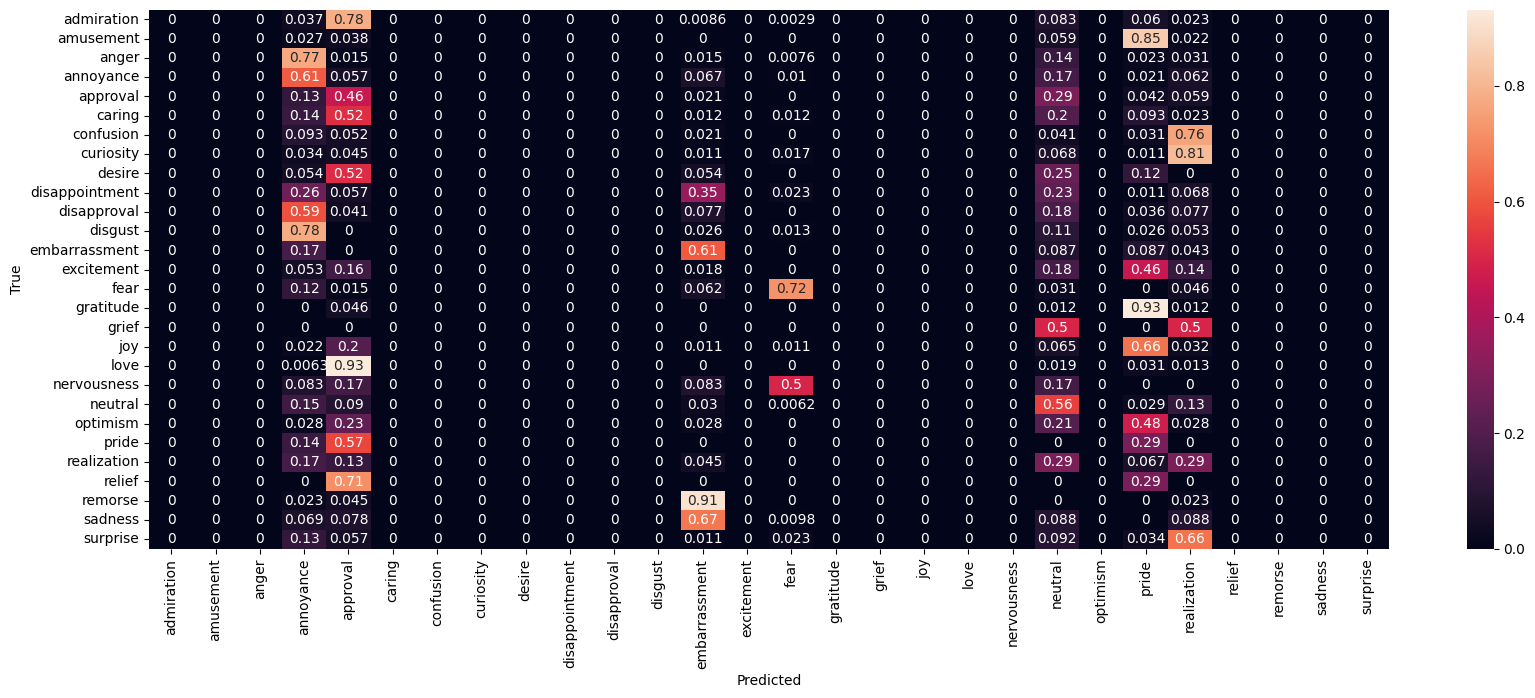

In [ ]:
plt.figure(figsize=(20,7))
sns.heatmap(
    cm, annot=True,
    xticklabels=target_names,
    yticklabels=target_names)
plt.xlabel("Predicted")
plt.ylabel("True")